In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd

In [2]:
# Hyperparameters
vocab_size = 1256
emb_dim = 384
n_heads = 8
dk = emb_dim // n_heads
context_length = 256
Nx = 6
dropout = 0.1


class PositionEncoding(tf.keras.layers.Layer):
    def __init__(self, context_length, d_model):
        super().__init__()
        self.context_length = context_length
        self.d_model = d_model

        position = tf.range(context_length, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(
            tf.range(0, d_model, 2, dtype=tf.float32)
            * (-tf.math.log(10000.0) / d_model)
        )

        pe = np.zeros((context_length, d_model), dtype=np.float32)
        pe[:, 0::2] = np.sin(position.numpy() * div_term.numpy())
        pe[:, 1::2] = np.cos(position.numpy() * div_term.numpy())
        self.pe = tf.constant(pe)[tf.newaxis, ...]

    def call(self, inputs):
        return self.pe[:, : tf.shape(inputs)[1], :]


class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, dk):
        super().__init__()
        self.initializer = tf.keras.initializers.GlorotUniform()
        self.WK = tf.Variable(self.initializer(shape=(emb_dim, dk)), trainable=True)
        self.WQ = tf.Variable(self.initializer(shape=(emb_dim, dk)), trainable=True)
        self.WV = tf.Variable(self.initializer(shape=(emb_dim, dk)), trainable=True)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.mask = 1 - tf.linalg.band_part(
            tf.ones((context_length, context_length)), -1, 0
        )
        self.mask = self.mask * -1e9

    def call(self, x, training=False):
        B, T, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]
        key = x @ self.WK
        query = x @ self.WQ
        value = x @ self.WV

        wei = query @ tf.transpose(key, [0, 2, 1])
        wei = wei / tf.math.sqrt(tf.cast(dk, tf.float32))
        wei = wei + self.mask[:T, :T]
        wei = tf.nn.softmax(wei, axis=-1)
        wei = self.dropout(wei, training=training)
        out = wei @ value
        return out


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, n_heads, dk):
        super().__init__()
        self.initializer = tf.keras.initializers.GlorotUniform()
        self.heads = [SelfAttention(dk) for _ in range(n_heads)]
        self.WO = tf.Variable(
            self.initializer(shape=(n_heads * dk, emb_dim)), trainable=True
        )
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x):
        out = tf.concat([h(x) for h in self.heads], axis=-1)
        out = out @ self.WO
        return out


class FeedForward(tf.keras.layers.Layer):
    def __init__(self, emb_dim):
        super().__init__()
        self.network = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(4 * emb_dim),
                tf.keras.layers.ReLU(),
                tf.keras.layers.Dense(emb_dim),
                tf.keras.layers.Dropout(dropout),
            ]
        )

    def call(self, x):
        return self.network(x)


class Block(tf.keras.layers.Layer):
    def __init__(self, emb_dim, dk, n_heads):
        super().__init__()
        self.attention = MultiHeadAttention(n_heads, dk)
        self.ffwd = FeedForward(emb_dim)
        self.ln1 = tf.keras.layers.LayerNormalization()
        self.ln2 = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = x + self.attention(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class DecoderTransformer(tf.keras.Model):
    def __init__(self , vocab_size , emb_dim , n_heads ,  Nx):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, emb_dim)
        self.pos_emb = PositionEncoding(context_length, emb_dim)
        self.blocks = tf.keras.Sequential(
            [Block(emb_dim, emb_dim // n_heads, n_heads) for _ in range(Nx)]
        )
        self.ln = tf.keras.layers.LayerNormalization()
        self.lm_head = tf.keras.layers.Dense(vocab_size)
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    def call(self, xb):
        te = self.token_emb(xb)
        pe = self.pos_emb(xb)
        emb = te + pe
        x = self.blocks(emb)
        x = self.ln(x)
        logits = self.lm_head(x)  # (B , T , vocab_size)
        return logits

    def compute_loss(self, xb, yb):
        logits = self(xb)
        logits_flat = tf.reshape(logits, (-1, logits.shape[2]))  # (B * T , vocab_size)
        target_flat = tf.reshape(yb, (-1))  # (B * T)
        loss = self.loss_fn(target_flat, logits_flat)
        loss = tf.reduce_mean(loss)
        return loss

In [3]:
def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]):
        counts[pair] = counts.get(pair, 0) + 1
    return counts

def merge_stats(tokens, pair, idx):
    new_tokens = []
    i = 0
    while i < len(tokens):
        if i < len(tokens) - 1 and tokens[i] == pair[0] and tokens[i+1] == pair[1]:
            new_tokens.append(idx)
            i += 2
        else:
            new_tokens.append(tokens[i])
            i += 1
    return new_tokens

class Tokenizer:
    def __init__(self):
        self.merges = {}
        self.vocab = {}

    def train(self, text, vocab_size, verbose=False):
        assert vocab_size >= 256
        num_merge = vocab_size - 256

        text_bytes = text.encode("utf-8")
        ids = list(text_bytes)

        merges = {}
        vocab = {idx: bytes([idx]) for idx in range(256)}

        for i in range(num_merge):
            stats = get_stats(ids)
            if not stats:
                break
            pair = max(stats, key=stats.get)
            idx = 256 + i
            ids = merge_stats(ids, pair, idx)
            merges[pair] = idx
            vocab[idx] = vocab[pair[0]] + vocab[pair[1]]
            if verbose:
                print(f"merge {i+1}/{num_merge}: {pair} -> {idx} ({vocab[idx]}) had {stats[pair]} occurrences")

        self.merges = merges
        self.vocab = vocab

    def encode(self, text):
        tokens = list(text.encode("utf-8"))
        while len(tokens) >= 2:
            stats = get_stats(tokens)
            pair = min(stats, key=lambda p: self.merges.get(p, float("inf")))
            if pair not in self.merges:
                break
            idx = self.merges[pair]
            tokens = merge_stats(tokens, pair, idx)
        return tokens

    def decode(self, ids):
        tokens = b"".join(self.vocab[idx] for idx in ids)
        text = tokens.decode("utf-8", errors="replace")
        return text

In [4]:
import pickle

with open("/kaggle/input/dostoevsky/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

In [ ]:
model = DecoderTransformer(vocab_size, emb_dim, n_heads, Nx)

In [6]:
with open("/kaggle/input/dostoevsky/The Prose Works of Fyodor Dostoevsky.txt" , "r", encoding='utf-8') as f:
    text = f.read()

In [7]:
encoded = tokenizer.encode(text)

In [8]:
print("encoded token length:", len(encoded))
print("text characters length:", len(text))
print(f"compression ratio: {len(text) / len(encoded):.2f}X")

encoded token length: 1032139
text characters length: 3079585
compression ratio: 2.98X


In [9]:
context_length = 256
buffer_size = 10000
batch_size = 64

In [10]:
token_ds = tf.data.Dataset.from_tensor_slices(encoded)

In [11]:
sequences = token_ds.window(size=context_length+1, shift=1, drop_remainder=True)
sequences = sequences.flat_map(lambda window: window.batch(context_length + 1))

In [12]:
def split_input_target(seq):
    input_text = seq[:-1]
    target_text = seq[1:]
    return input_text, target_text

In [13]:
dataset = sequences.map(split_input_target)

In [14]:
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [15]:
for element in dataset.as_numpy_iterator():
  x , y = element
  print(x.shape)
  print(y.shape)
  break

(64, 256)
(64, 256)


In [16]:
count = 0
for _ in dataset:
    count += 1
print(f"The dataset has {count} elements.")

The dataset has 16123 elements.


In [17]:
total_training_steps = 16123 
warmup_steps = 1500
peak_learning_rate = 3e-4
final_learning_rate = 1e-5 

class StableSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, peak_lr, warmup_steps, total_steps, final_lr):
        super().__init__()
        self.peak_lr = peak_lr
        self.warmup_steps = float(warmup_steps)
        self.total_steps = float(total_steps)
        self.final_lr = final_lr

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)

        warmup_factor = step / self.warmup_steps
        warmup_lr = self.peak_lr * warmup_factor

        # Cosine Decay 
        progress = (step - self.warmup_steps) / (self.total_steps - self.warmup_steps)
        
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        
        
        cosine_decay = 0.5 * (1.0 + tf.cos(np.pi * progress))
        
        decayed_lr = (self.peak_lr - self.final_lr) * cosine_decay + self.final_lr

        
        return tf.where(step < self.warmup_steps, warmup_lr, decayed_lr)

learning_rate_schedule = StableSchedule(peak_learning_rate, warmup_steps, total_training_steps, final_learning_rate)

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate_schedule)

In [19]:
for inp_batch , target_batch in dataset.take(1):
    _ = model(inp_batch)
    print("Model has been successfully built by processing one batch.")
total_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])
print(f"\nThe model has {int(total_params):,} trainable parameters.")

Model has been successfully built by processing one batch.

The model has 8,065,256 trainable parameters.


In [20]:
losses = []
for step , (xb , yb) in enumerate(dataset):
    with tf.GradientTape() as tape:
        loss = model.compute_loss(xb,yb)
    grad = tape.gradient(loss , model.trainable_variables)
    clipped_gradients, _ = tf.clip_by_global_norm(grad, 1.0)
    optimizer.apply_gradients(zip(clipped_gradients, model.trainable_variables))
    losses.append(loss)
    if (step+1) % 50 == 0 :
        print(f"Step {step + 1}/{total_training_steps}, Loss: {loss.numpy():.4f}")
    if losses[-1] < 0.3:
        break

Step 50/16123, Loss: 7.0922
Step 100/16123, Loss: 6.6877
Step 150/16123, Loss: 6.4537
Step 200/16123, Loss: 6.3381
Step 250/16123, Loss: 6.3490
Step 300/16123, Loss: 6.3320
Step 350/16123, Loss: 6.3677
Step 400/16123, Loss: 6.3438
Step 450/16123, Loss: 6.3169
Step 500/16123, Loss: 6.3442
Step 550/16123, Loss: 6.3435
Step 600/16123, Loss: 6.2785
Step 650/16123, Loss: 5.9324
Step 700/16123, Loss: 5.4576
Step 750/16123, Loss: 5.1746
Step 800/16123, Loss: 4.9336
Step 850/16123, Loss: 4.7284
Step 900/16123, Loss: 4.4958
Step 950/16123, Loss: 4.3381
Step 1000/16123, Loss: 4.2789
Step 1050/16123, Loss: 4.1978
Step 1100/16123, Loss: 4.1051
Step 1150/16123, Loss: 3.9315
Step 1200/16123, Loss: 4.0586
Step 1250/16123, Loss: 3.7754
Step 1300/16123, Loss: 3.6204
Step 1350/16123, Loss: 3.6381
Step 1400/16123, Loss: 3.3720
Step 1450/16123, Loss: 3.3371
Step 1500/16123, Loss: 3.2749
Step 1550/16123, Loss: 3.1402
Step 1600/16123, Loss: 3.1336
Step 1650/16123, Loss: 2.8802
Step 1700/16123, Loss: 2.7509


In [21]:
losses[-1]

<tf.Tensor: shape=(), dtype=float32, numpy=0.2792503833770752>

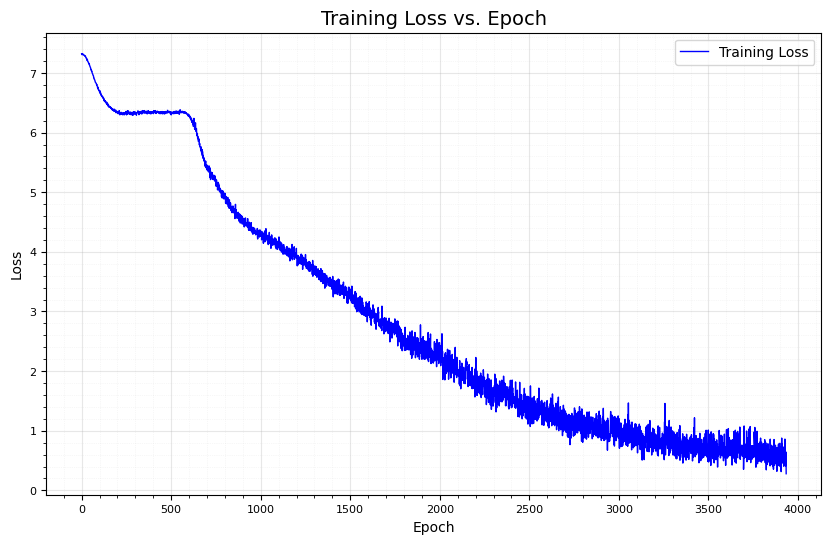

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(losses, linestyle='-',linewidth=1, color='blue', label='Training Loss')


plt.title('Training Loss vs. Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.grid(True, alpha=0.3)

plt.legend(fontsize=10)

plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', alpha=0.2)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8  )
plt.savefig("epochs vs loss")
plt.show()

In [23]:

generated = []
context = [0] * context_length  # Start context

for _ in range(500):  # Generate 350 tokens
    Xb = tf.constant([context], dtype=tf.int32)  # Shape (1, T)

    logits = model.call(Xb)

    # Take the logits at the last position
    last_logits = logits[:, -1, :]              # (1, vocab_size)
    probs = tf.nn.softmax(last_logits, axis=-1) # (1, vocab_size)

    ix = tf.random.categorical(tf.math.log(probs), num_samples=1)[0, 0].numpy()
    context = context[1:] + [ix]  # Slide the context window
    generated.append(ix)

In [26]:

decoded = tokenizer.decode(generated)
print("Decoded:", decoded)

Decoded: had heard without the . We shall fastrible to dirested upon too. ch had heard not. en. It's not such shcountown such I've come livulsion will understand how before) Of courll in the monks, not
of a ball a
share
man will (emthough she can refuse 'words. Your children will understand that you latert of for you in once into my shelp placp taken't I town that? I knew I would on my duty end, where I did not love them. All me one followed what and if she didn't think about it, would
how came to understand they everything.
"Ah, you thought and so, how was you can possibly be es to hem in tthere's no dying. All of tenge two years to feel it is not sitting in my dd bovse says on me to Himea child, nor
come perhaps once had after at the fight
nearly about my character, the dampty of God to
stairinto the bar, he in die fficultly left vtrembbarcastic they midaterinvage of no
fall of his thought had by
dage two thought before his children. Wit.
Then (addy. The laternothings was sat if he 

In [30]:
model.save_weights('dostoevsky.weights.h5')
print("Model weights saved successfully.")

Model weights saved successfully.


## Saving 5000 lines of sampled text

In [28]:
generated = []
context = [0] * context_length  # Start context

for _ in range(5000):  # Generate 350 tokens
    Xb = tf.constant([context], dtype=tf.int32)  # Shape (1, T)

    logits = model.call(Xb)

    # Take the logits at the last position
    last_logits = logits[:, -1, :]              # (1, vocab_size)
    probs = tf.nn.softmax(last_logits, axis=-1) # (1, vocab_size)

    ix = tf.random.categorical(tf.math.log(probs), num_samples=1)[0, 0].numpy()
    context = context[1:] + [ix]  # Slide the context window
    generated.append(ix)
decoded = tokenizer.decode(generated)
with open("sample.txt" , "w") as f:
    f.write(decoded)

In [29]:
print("Decoded:", decoded)

Decoded: as well of I have satisolation my looks reflecial echstristic to be but openut everything, she can not at lestand their to this on their vifts and aAlexched the creature. A birned get catchant and suddenly simply his eyes rest love ggrined of hewere contorted
last tender abantly. The Father Zossima's Youth before
then that it's fours? Is it lives not still unable to refused some, are beloved me on
minute papible ignificult:s
nothing traced up refuse to hurch qutors
visors long at their heart. Good Go one roon as though
later havinglecreation before:
"God remembgard after the deaths everyone was not to feel it is not such interesting, some trready caours; aret skenfe and live, and betraise his hands, his eyes sbe'ind-beard and feard, 'people
have sewhole lled that:
I look at the
face to begin you to have told you." Skistsuasting me, on give another it get up again,
and it will be essend it, don't since the bonverent lies as truth him. Why should I for? I am
ever have come more 